## Exploratory Data Analysis

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# checking no. of instances and no. of columns in dataset
df.shape

(50000, 2)

In [ ]:
df.info()
# no missing values found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# checking no. of instances for each class
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Movie Sentiment')

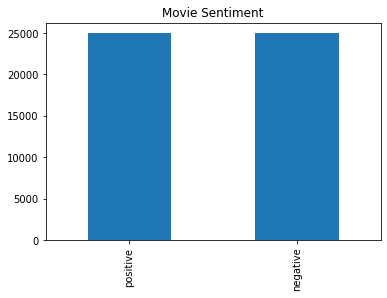

In [ ]:
# visualizing the same using bar graph
df.sentiment.value_counts().plot(kind = "bar")
plt.title("Movie Sentiment")
# we observe both classes are perfectly balanced with each class having 25000 instances

In [ ]:
# separating dependent(y) and independent(X) variables
X = df.iloc[:, 0] 
y = df.iloc[:, 1]
# splitting data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Bag of Words (n-grams) models

### Data Pre-processing

In [ ]:
# importing libraries
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# encoding the sentiment column as 0 and 1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
# creating a Preprocessing class containing all preprocessing required to the text data
class Preprocessing:
    '''Preprocesses the given column and returns data that is ready to feed to the model'''
    
    def __init__(self):
        # initializing objects for different preprocessing techniques
        self.stop_words = stopwords.words('english')
        self.lemmatizer = WordNetLemmatizer()
        self.vectorizer = TfidfVectorizer(ngram_range=(1,2))
        self.selector = None
        self.training = None
        
    
    def remove_html_tags(self, text):
        # Remove html tags from a string
        html_free = re.compile('<.*?>')
        html_free = re.sub(html_free, '', text)
        return html_free


    def remove_punctuations(self, text):
        # removes unnecessary punctuations from the text
        text = text.lower()
        cleaned_text = re.findall("[a-zA-Z]+", text)
        
        return cleaned_text
    

    def lemmatize(self, text):
        # brings words to their root words i.e. acting -> act
        cleaned_text = ' '.join([self.lemmatizer.lemmatize(i) for i in text])
        
        return cleaned_text
    
    
    def vectorize(self, X_cleaned): 
        # converts text data to vectorized form such that it can be feeded to the models
        if self.training:
            self.vectorizer.fit(X_cleaned)
            
        # converting text to vectorized form
        X_vectorized = self.vectorizer.transform(X_cleaned)
        
        return X_vectorized


    def feature_selection(self, X_vectorized, train_labels=None):
        # selects top 20K features by feature importance using f_classif
        if self.training:
            self.selector = SelectKBest(f_classif, k=min(20000, X_vectorized.shape[1]))
            self.selector.fit(X_vectorized, train_labels)
        
        # Select top 'k' of the vectorized features
        X_selected = self.selector.transform(X_vectorized).astype('float32')

        return X_selected
        
    
    def preprocess(self, X, train_labels=None, training=True):
        # takes input column and applies different pre-processing techniques
        X_cleaned = pd.DataFrame()
        self.training = training
        X = X.apply(lambda x: self.remove_html_tags(x))
        X = X.apply(lambda x: self.remove_punctuations(x))
        # X = X.apply(lambda x: self.stop_words_remover(x))
        X_cleaned = X.apply(lambda x: self.lemmatize(x))
        X_vectorized = self.feature_selection(self.vectorize(X_cleaned), train_labels)
        
        return X_cleaned, X_vectorized

In [ ]:
# preprocessing training data
pp = Preprocessing()
X_train_cleaned, X_train_vectorized = pp.preprocess(X=X_train, train_labels=y_train_encoded)

In [ ]:
# preprocessing test data
X_test_cleaned, X_test_vectorized = pp.preprocess(X=X_test, training=False)

Text(0.5, 1.0, 'The most frequent words used in positive sentiment')

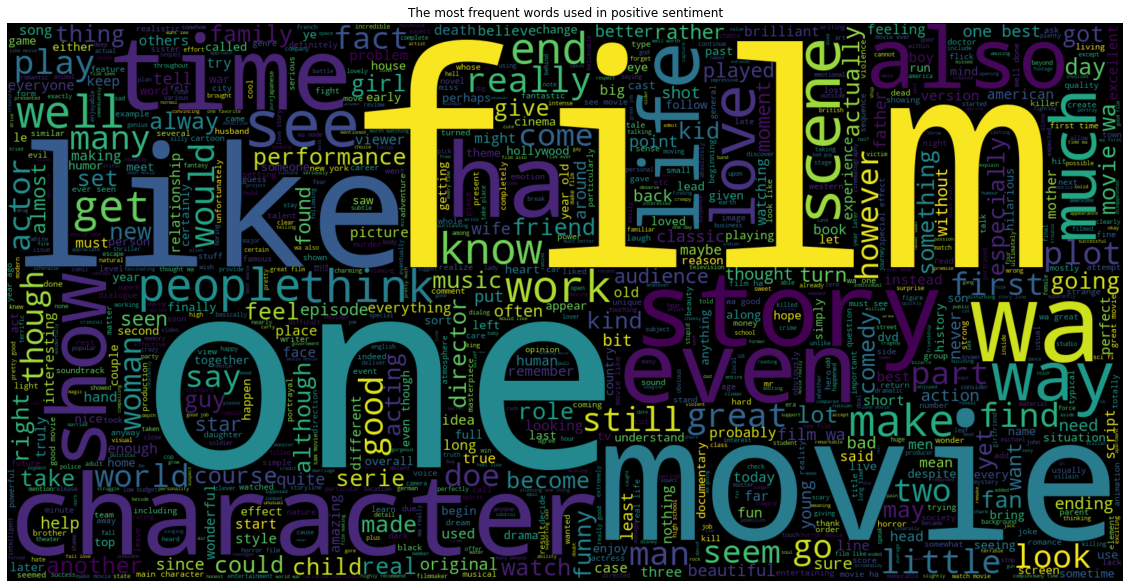

In [ ]:
# Analysing the words used in positive sentiments 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stop_words = stopwords.words('english')
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(X_train_cleaned[y_train_encoded == 1]))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.title("The most frequent words used in positive sentiment")

Text(0.5, 1.0, 'The most frequent words used in negative sentiment')

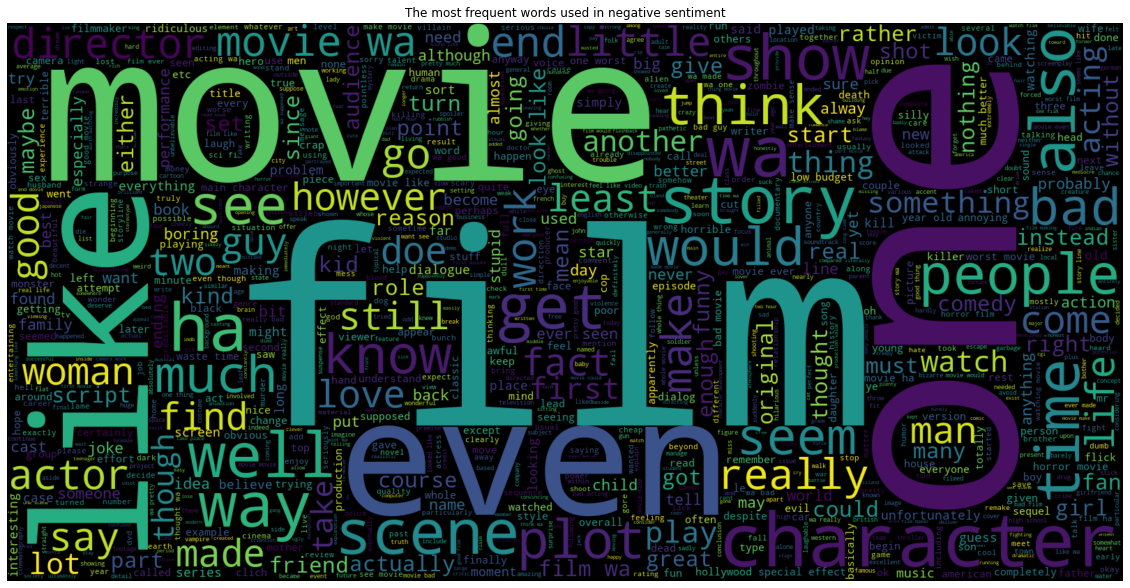

In [ ]:
# Analysing the words used in negative sentiments 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stop_words = stopwords.words('english')
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(X_train_cleaned[y_train_encoded == 0]))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.title("The most frequent words used in negative sentiment")

### Model Building

#### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

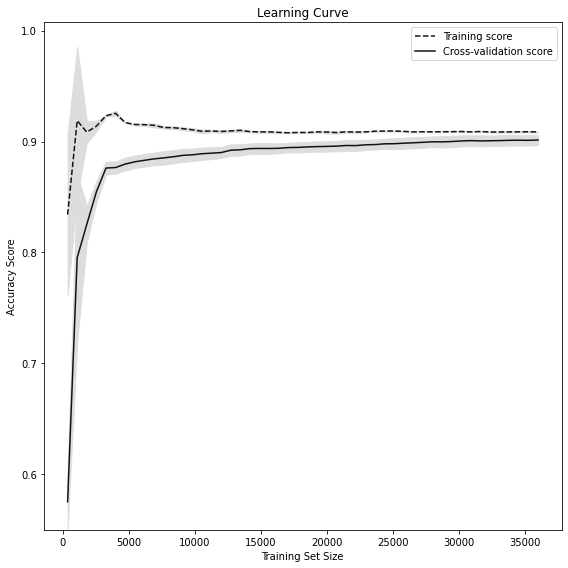

In [ ]:
from sklearn.model_selection import learning_curve
# training the model and plotting learning curve
mnb_model = MultinomialNB()

train_sizes, train_scores, test_scores = learning_curve(mnb_model, X_train_vectorized, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.ylim(bottom=0.55)
plt.show()

In [ ]:
# model performance on different metrics
mnb_model.fit(X_train_vectorized, y_train_encoded)
y_pred = mnb_model.predict(X_test_vectorized)

print('Classification Report:\n', classification_report(y_test_encoded, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test_encoded, y_pred))
print("Accuracy score: ", accuracy_score(y_test_encoded, y_pred))
# scores below reflect that model is generalized, but confusion matrix suggests that there is still scope of improvement

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
 [[4366  595]
 [ 497 4542]]
Accuracy score:  0.8908


##### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid=[{'alpha': np.linspace(0.5, 1.5, 6),  
             'fit_prior': [True, False],
            }]

grid = GridSearchCV(mnb_model, param_grid=param_grid, cv=10, scoring='accuracy', verbose=True, n_jobs=-1)
grid.fit(X_train_vectorized, y_train_encoded)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                          'fit_prior': [True, False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=True)

In [ ]:
print(grid.best_params_)

{'alpha': 0.5, 'fit_prior': True}


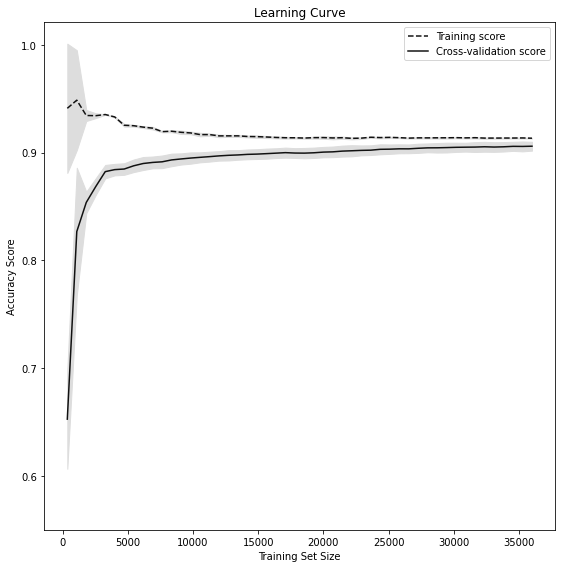

In [ ]:
# using above found best params and training the model and plotting learning curve
mnb_model_tuned = MultinomialNB(alpha=0.5, fit_prior=True)

train_sizes, train_scores, test_scores = learning_curve(mnb_model_tuned, X_train_vectorized, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.ylim(bottom=0.55)
plt.show()
# from the below plot we understand that model is performing well and is able to generalize

In [ ]:
# tuned model perfromance
mnb_model_tuned.fit(X_train_vectorized, y_train_encoded)
y_pred = mnb_model_tuned.predict(X_test_vectorized)

print('Classification Report:\n', classification_report(y_test_encoded, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test_encoded, y_pred))
print("Accuracy score: ", accuracy_score(y_test_encoded, y_pred))
# scores below suggest that there is a minute increase in performance of the model and is also reflected in confusion matrix obtained

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
 [[4365  596]
 [ 488 4551]]
Accuracy score:  0.8916


#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

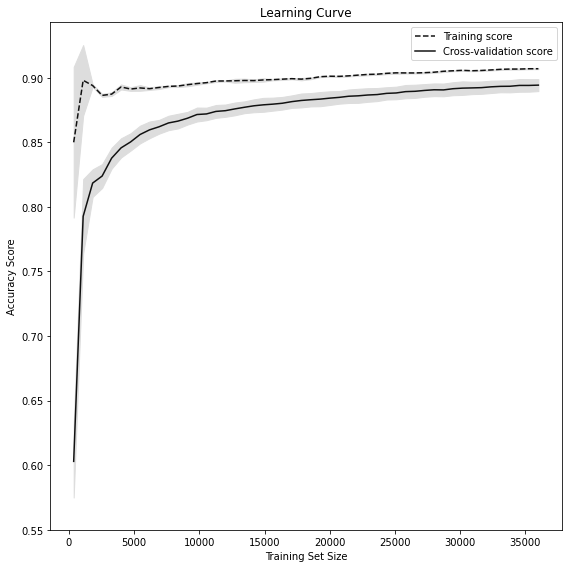

In [ ]:
# training the model and plotting learning curve
lor_model = LogisticRegression()

train_sizes, train_scores, test_scores = learning_curve(lor_model, X_train_vectorized, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.ylim(bottom=0.55)
plt.show()
# from the below plot we understand that model is performing well and is able to generalize

In [ ]:
# model performance
lor_model.fit(X_train_vectorized, y_train_encoded)
y_pred = lor_model.predict(X_test_vectorized)

print('Classification Report:\n', classification_report(y_test_encoded, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test_encoded, y_pred))
print("Accuracy score: ", accuracy_score(y_test_encoded, y_pred))
# the scores below reflect that the logistic regression is performing a bit better than the naive bayes(tuned) model

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion Matrix:
 [[4368  593]
 [ 453 4586]]
Accuracy score:  0.8954


##### Hyperparameter Tuning

In [ ]:
param_grid=[{'penalty':['l1', 'l2'],
             'C':[0.01,0.1,1,10,100,1000],
             }]

grid = GridSearchCV(lor_model, param_grid=param_grid, cv=10, scoring='accuracy', verbose=True)
grid.fit(X_train_vectorized, y_train_encoded)

In [ ]:
print(grid.best_params_)

{'C': 100, 'penalty': 'l2'}


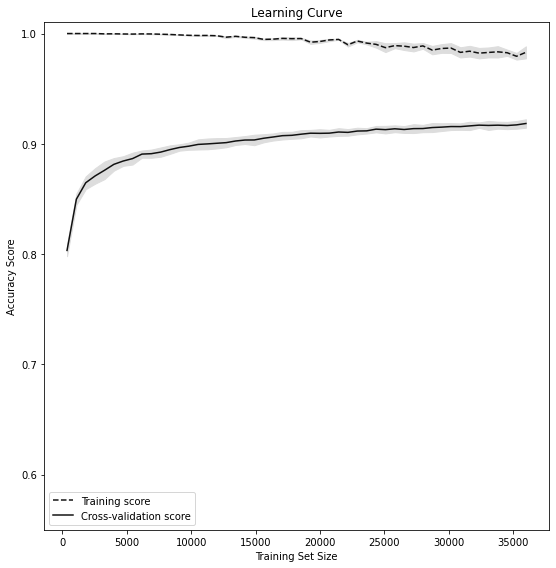

In [ ]:
# using above found best params and training the model and plotting learning curve
lor_model_tuned = LogisticRegression(C=100, penalty='l2')

train_sizes, train_scores, test_scores = learning_curve(lor_model_tuned, X_train_vectorized, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.ylim(bottom=0.55)
plt.show()
# we can see that with increase in training samples, validation accuracy is increasing but there is a bit of generalization gap

In [ ]:
# tuned model performance
lor_model_tuned.fit(X_train_vectorized, y_train_encoded)
y_pred = lor_model_tuned.predict(X_test_vectorized)

print('Classification Report:\n', classification_report(y_test_encoded, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test_encoded, y_pred))
print("Accuracy score: ", accuracy_score(y_test_encoded, y_pred))
# here the scores look good but the generalization gap says that the model is overfitting and might not be a good choice for production environment 

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      4961
           1       0.90      0.92      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:
 [[4471  490]
 [ 421 4618]]
Accuracy score:  0.9089


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Multi Layer Perceptron

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# defining the architecture
def multi_layer_perceptron():
    model = models.Sequential()
    model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
import tensorflow as tf

# setting callback for early stopping if model doesn't improve over 2 iterations after last achieved lowest validation loss
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

mlp_model = multi_layer_perceptron()
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
                  )

In [ ]:
# training the model
history = mlp_model.fit(X_train_vectorized.toarray(), 
                        y_train_encoded, 
                        epochs=70, 
                        batch_size=128, 
                        callbacks=callbacks, 
                        validation_data=(X_test_vectorized.toarray(), y_test_encoded), 
                        verbose=2)

Epoch 1/70
313/313 - 10s - loss: 0.6606 - accuracy: 0.8380 - val_loss: 0.6261 - val_accuracy: 0.8614
Epoch 2/70
313/313 - 9s - loss: 0.6019 - accuracy: 0.8712 - val_loss: 0.5726 - val_accuracy: 0.8660
Epoch 3/70
313/313 - 9s - loss: 0.5550 - accuracy: 0.8742 - val_loss: 0.5293 - val_accuracy: 0.8706
Epoch 4/70
313/313 - 9s - loss: 0.5158 - accuracy: 0.8791 - val_loss: 0.4940 - val_accuracy: 0.8729
Epoch 5/70
313/313 - 9s - loss: 0.4839 - accuracy: 0.8819 - val_loss: 0.4646 - val_accuracy: 0.8766
Epoch 6/70
313/313 - 9s - loss: 0.4564 - accuracy: 0.8870 - val_loss: 0.4399 - val_accuracy: 0.8792
Epoch 7/70
313/313 - 9s - loss: 0.4332 - accuracy: 0.8887 - val_loss: 0.4188 - val_accuracy: 0.8819
Epoch 8/70
313/313 - 9s - loss: 0.4136 - accuracy: 0.8918 - val_loss: 0.4007 - val_accuracy: 0.8847
Epoch 9/70
313/313 - 9s - loss: 0.3953 - accuracy: 0.8963 - val_loss: 0.3848 - val_accuracy: 0.8879
Epoch 10/70
313/313 - 9s - loss: 0.3798 - accuracy: 0.8961 - val_loss: 0.3707 - val_accuracy: 0.889

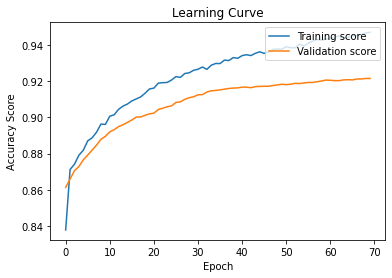

In [ ]:
# plotting the learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('Accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Training score', 'Validation score'], loc = 'upper right')
plt.show()
# below plot shows that training and validation accuracies are increasing at every epoch but there is a generalization gap

In [ ]:
# checking the performance of models on various metrics
y_pred = mlp_model.predict(X_test_vectorized, batch_size=128)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print('Classification Report:\n', classification_report(y_test_encoded, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test_encoded, y_pred))
print("Accuracy score: ", accuracy_score(y_test_encoded, y_pred))
# we can see that our model is classifying both the classes pretty good

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      4961
           1       0.92      0.93      0.92      5039

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Confusion Matrix:
 [[4530  431]
 [ 355 4684]]
Accuracy score:  0.9214


### Testing the trained models

In [ ]:
# testing on a bit confusing review
sentiment = 'i liked the actors but not the movie'
input = pd.Series(sentiment)
sentiment_cleaned, sentiment_vectorized = pp.preprocess(input, training=False)

In [ ]:
sentiment_cleaned[0]

'i liked the actor but not the movie'

**Mulitnomial Naive Bayes**

In [ ]:
pred = mnb_model_tuned.predict(sentiment_vectorized)
proba = mnb_model_tuned.predict_proba(sentiment_vectorized)
if pred == 1:
    print("It is a positive review")
    proba = proba[:, 1]
else:
    print("It is a negative review") 
    proba = proba[:, 0]

It is a negative review


In [ ]:
print('Prediction Probability: %.2f' % (proba[0] * 100))

Prediction Probability: 53.94


**Logistic Regression**

In [ ]:
pred = lor_model.predict(sentiment_vectorized)
proba = lor_model.predict_proba(sentiment_vectorized)
if pred == 1:
    print("It is a positive review")
    proba = proba[:, 1]
else:
    print("It is a negative review") 
    proba = proba[:, 0]

It is a positive review


In [ ]:
print('Prediction Probability: %.2f' % (proba[0] * 100))

Prediction Probability: 51.70


**Multi Layer Perceptron**

In [ ]:
proba = mlp_model.predict(sentiment_vectorized)
if proba >= 0.5:
    print("It is a positive review")
else:
    print("It is a negative review") 
    proba = 1 - proba

It is a positive review


In [ ]:
print('Prediction Probability: %.2f' % (proba[0] * 100))

Prediction Probability: 56.05


## Saving the selected model for deployment

In [ ]:
import pickle

# pickling the preprocessing objects to retrieve the object parameters
pickle.dump(pp.selector, open('/content/drive/MyDrive/Movie Review Classification/selector.pkl', 'wb'))
pickle.dump(pp.vectorizer, open('/content/drive/MyDrive/Movie Review Classification/vectorizer.pkl', 'wb'))

In [ ]:
# pickling the Mulitnomial Naive Bayes Model since it was giving great results and also it had less generalization gap
pickle.dump(mnb_model_tuned, open('/content/drive/MyDrive/Movie Review Classification/MNB_Model.sav', 'wb'))